# Finding locations in Kauai for a State Farm Dealership
## Final Report for Coursera IBM Applied Data Science Capstone
## *Charles Vuono*

### Introduction / Business Problem
State Farm Insurance is a national chain of independently owned insurance dealerships who contract with State Farm for the right to establish a dealership which will exclusively sell State Farm insurance products from a retail location. Currently, the island of Kauai, Hawaii has no State Farm dealerships. Supposing that we are interested in opening a State Farm dealership on Kauai, the purpsose of this investigation is to understand the characteristics of locations that currently support State Farm Dealerships elsewhere in Hawaii and compare them with various areas of Kauai to determine suitable candidates to establish a State Farm dealership. We will study existing State Farm Dealership locations through a variety of descriptive and predictive analytic techniques on neighborhood data, using these results to find similar Kauai neighborhoods.

### Data
We will use two primary data sources to conduct our investigation:
1. Location data on every existing State Farm dealership in the United States, including longitude, latitude and full address (approximately 19,000 records)
2. Neighborhood data from the FourSquare Developer API regarding the types of commercial establishments in proximity to these dealerships.

To prepare the data set, we will load relevant Python libraries and then acquire the State Farm and the FourSquare data. Finally we will load data on potential Kauai agency locations.



In [1]:
# Load Python libraries:
import types
import pandas as pd
import random # library for random number generation
import numpy as np # library for vectorized computation

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

import requests
import urllib.request

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't installed folium
#import folium # map rendering library

# For logistic regression
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# For graphing in seaborn
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

print('Libraries and packages loaded.')



Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

In [2]:
# The code was removed by Watson Studio for sharing.

The State Farm data consists of 18872 rows and 18 columns.
Restricting the data to locational data looks as follows:


,latitude,longitude,city,state,zip
0,42.885943,-77.280766,Canandaigua,NY,14424-1506
1,45.863906,-95.373885,Alexandria,MN,56308
2,41.051858,-76.220358,Nescopeck,PA,18635-0502
3,41.140139,-112.037307,Clinton,UT,84015-6608
4,38.475771,-81.079581,Clay,WV,25043-7001


The next step is to restrict the State Farm agency location data to Hawaii and turn our attention to acquiring the FourSquare data on venues in the areas surrounding these agencies.

In [6]:
# LOAD THE FOURSQUARE DATA for State Farm Locations in Hawaii

# Define Four Square Credentials
CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20180604'

# Create a function to explore neighborhoods with FourSquare data

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name) # comment or uncomment to unshow / show names
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
                    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Store', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        
    return(nearby_venues)

# Get venues # edit this so it is Hawaii not Toronto

# limit to neighborhoods in Hawaii
hawaii_data = sfdf[sfdf['state']=='HI'].reset_index(drop=True)
citylist = hawaii_data['city']


# Name the stores
storenames = pd.Series([]) #initiate the Series
i=0
while i < len(hawaii_data):
    currentcity = citylist[i]
    listsofar = citylist[0:i]
    occurrencessofar = sum(listsofar==currentcity)
    samecityprior=occurrencessofar+1
    storename = currentcity+str(samecityprior)
    storenames[i] = storename
    i=i+1
hawaii_data['store'] = storenames
    
# Get the venues using the getNearbyVenues function created above and store in a Pandas data frame hawaii_venues

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
      
hawaii_venues = getNearbyVenues(names=hawaii_data['store'],latitudes=hawaii_data['latitude'], longitudes=hawaii_data['longitude'])
hawaii_venues.head()


,Store,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kaneohe1,21.418904,-157.802846,A Place of Perfection,21.419359,-157.804072,Spa
1,Kaneohe1,21.418904,-157.802846,Fresh Catch,21.417109,-157.801815,Seafood Restaurant
2,Kaneohe1,21.418904,-157.802846,Gyu-Kaku Japanese BBQ,21.419692,-157.805073,Japanese Restaurant
3,Kaneohe1,21.418904,-157.802846,Macy's,21.420000,-157.805000,Department Store
4,Kaneohe1,21.418904,-157.802846,El Mariachi,21.418171,-157.801857,Mexican Restaurant


Finally, we load location data on the various areas of Kauai and acquire the foursquare data on those neighborhoods as well.

In [7]:
# Load the Kauai location Data

body = client_XXXbe.get_object(Bucket='courseracapstoneproject-donotdelete-pr-4heymww7swidw3',Key='Kauai Towns csv.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
kauai_data = pd.read_csv(body)
kauai_data.head()


# Match the Kauai location data with the venue data from FourSquare

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
      
kauai_venues = getNearbyVenues(names=kauai_data['Town'],latitudes=kauai_data['Latitude'], longitudes=kauai_data['Longitude'])
kauai_venues.head()


,Store,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Haena,22.221399,-159.546387,Wainiha Bay,22.218898,-159.543927,Beach
1,Haena,22.221399,-159.546387,Hanalei Colony Resort,22.221453,-159.545230,Resort
2,Haena,22.221399,-159.546387,Na Pali Art Gallery And Coffee House,22.221889,-159.545516,Coffee Shop
3,Haena,22.221399,-159.546387,Kalalau B&B,22.221296,-159.546609,Bed & Breakfast
4,Haena,22.221399,-159.546387,Opakapaka Grill and Bar,22.221963,-159.545376,Restaurant


### Methodology 
We shall approach our problem from several angles:
1. Descriptive analysis of neighborhoods of existing State Farm agencies on other islands in Hawaii.
2. K-means clustering on existing State Farm locations and their nearby venues which will be used to measure potential Kauai locations based on the size of the overall cluster they adhere to as well as their distance to the centroid of that cluster.

We shall find a list of potential locations in Kauai using these two approaches, and develop a final list of potential locations based on those locations which are present on both lists.

#### Preparing the Data for analysis
First we will organize the data in both a normalized data frame (showing a weighted presence of venues near each agency or potential agency location) and a data frame listing the most common venue near each agency or potential agency location.
First we prepare the data frames on the existing locations.

In [9]:
# Get a normalized data frame on existing agencies in Hawaii

# one hot encoding
hawaii_onehot = pd.get_dummies(hawaii_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hawaii_onehot['Store'] = hawaii_venues['Store'] 

# move neighborhood column to the first column
fixed_columns = [hawaii_onehot.columns[-1]] + list(hawaii_onehot.columns[:-1])
hawaii_onehot = hawaii_onehot[fixed_columns]

# create grouped data frame
hawaii_grouped = hawaii_onehot.groupby('Store').mean().reset_index()


hawaii_grouped.head()

,Store,ATM,Acai House,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Aiea1,0.0,0.0,0.012821,0.0,0.012821,0.0,0.0,0.0,0.0,...,0.0,0.0,0.012821,0.012821,0.0,0.0,0.012821,0.000000,0.025641,0.0
1,Aiea2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.035714,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,Aiea3,0.0,0.0,0.000000,0.0,0.028571,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.028571,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,Aiea4,0.0,0.0,0.000000,0.0,0.026316,0.0,0.0,0.0,0.0,...,0.0,0.0,0.026316,0.026316,0.0,0.0,0.026316,0.000000,0.052632,0.0
4,Aiea5,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.041667,0.000000,0.0


In [10]:
# Reshape the normalied data frame to list most frequent venue near each store
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Store']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe for most common venues near Hawaii Stores
hawaii_venues_sorted = pd.DataFrame(columns=columns)
hawaii_venues_sorted['Store'] = hawaii_grouped['Store']

for ind in np.arange(hawaii_grouped.shape[0]):
    hawaii_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hawaii_grouped.iloc[ind, :], num_top_venues)

hawaii_venues_sorted.head()

,Store,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aiea1,Clothing Store,Pizza Place,Cosmetics Shop,Mobile Phone Shop,Fast Food Restaurant,Coffee Shop,Kids Store,Bakery,Lingerie Store,Sushi Restaurant
1,Aiea2,Restaurant,Martial Arts Dojo,Noodle House,Sporting Goods Shop,Chinese Restaurant,Sushi Restaurant,Asian Restaurant,Snack Place,Liquor Store,Cajun / Creole Restaurant
2,Aiea3,Restaurant,Martial Arts Dojo,Noodle House,Chinese Restaurant,Sushi Restaurant,Sporting Goods Shop,Liquor Store,Japanese Restaurant,Furniture / Home Store,Juice Bar
3,Aiea4,Clothing Store,Pizza Place,Shoe Store,Bakery,Fast Food Restaurant,Chinese Restaurant,Women's Store,Mobile Phone Shop,Italian Restaurant,Supplement Shop
4,Aiea5,Convenience Store,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant,Cosmetics Shop,Japanese Restaurant,Noodle House,Coffee Shop,Restaurant,Sandwich Place


Next we perform the same set of operations on the potential agency locations in Kauai.

In [11]:
# Get a normalized data frame on potential agency locations in Kauai

# one hot encoding
kauai_onehot = pd.get_dummies(kauai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kauai_onehot['Store'] = kauai_venues['Store'] 

# move neighborhood column to the first column
fixed_columns = [kauai_onehot.columns[-1]] + list(kauai_onehot.columns[:-1])
kauai_onehot = kauai_onehot[fixed_columns]

# create grouped data frame
kauai_grouped = kauai_onehot.groupby('Store').mean().reset_index()


kauai_grouped.head()

,Store,Accessories Store,American Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,...,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Trail,Travel & Transport,Wine Shop,Women's Store,Yoga Studio
0,Haena,0.00000,0.000000,0.0,0.00000,0.00000,0.000000,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000
1,Hanalei,0.02439,0.000000,0.0,0.02439,0.04878,0.024390,0.0,0.02439,0.0,...,0.0,0.0,0.02439,0.02439,0.0,0.0,0.0,0.0,0.02439,0.024390
2,Hanamaulu,0.00000,0.000000,0.0,0.00000,0.00000,0.000000,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000
3,Hanapepe,0.00000,0.000000,0.0,0.00000,0.00000,0.100000,0.0,0.00000,0.1,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.1,0.0,0.00000,0.000000
4,Kalaheo,0.00000,0.052632,0.0,0.00000,0.00000,0.052632,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.052632


In [12]:
# create a new dataframe for most common venues near Hawaii Stores
kauai_venues_sorted = pd.DataFrame(columns=columns)
kauai_venues_sorted['Store'] = kauai_grouped['Store']

for ind in np.arange(kauai_grouped.shape[0]):
    kauai_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kauai_grouped.iloc[ind, :], num_top_venues)

kauai_venues_sorted.head()

,Store,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Haena,Spa,Beach,Resort,Restaurant,Scenic Lookout,Bed & Breakfast,Coffee Shop,Flower Shop,Furniture / Home Store,Convenience Store
1,Hanalei,Seafood Restaurant,Food Truck,BBQ Joint,Ice Cream Shop,Beach,Board Shop,Dessert Shop,Pizza Place,Shopping Mall,Yoga Studio
2,Hanamaulu,Hawaiian Restaurant,Cosmetics Shop,Restaurant,Gas Station,Design Studio,Fish Market,Boutique,Electronics Store,Deli / Bodega,Dessert Shop
3,Hanapepe,Dessert Shop,Bakery,Mexican Restaurant,Restaurant,Baseball Field,Ice Cream Shop,Breakfast Spot,Herbs & Spices Store,Gas Station,Travel & Transport
4,Kalaheo,Park,Pizza Place,Yoga Studio,Café,Italian Restaurant,Liquor Store,Music Store,Noodle House,Pharmacy,Pie Shop


#### Exploratory Data Analysis
We are now in a position to provide basic descriptive analytics regarding the venues surrounding existing agencies elsewhere in Hawaii and compare them to the venues surrounding the potential locations in Kauai. 

Let us begin by looking at a map of existing locations (indicated in *blue*) and a map of potential locations (indicated in *red*).

In [22]:
# Map existing locations in Folium in blue and potential locations in Kauai in red
#!conda install -c conda-forge folium #uncomment if not installed
import folium
map_existing = folium.Map(location=[21.2, -158.5], zoom_start=8)

# add markers to map
for lat, lng, stor in zip(hawaii_data['latitude'], hawaii_data['longitude'], hawaii_data['store']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_existing)
    
for lat, lng, stor in zip(kauai_data['Latitude'], kauai_data['Longitude'], kauai_data['Town']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_existing) 
    
map_existing

Next we shall consider the prevelance of the most common venue of existing locations and comparing this to the prevalence of the most common venues of our potential agency locations in Kauai.

To begin, we shall create a data frame with the percent frequency of the most common venue near each existing and potential location and look at the level of overlap.

In [23]:
# Counts of most common venues near existing locations
existingcounts = hawaii_venues_sorted['1st Most Common Venue'].value_counts(normalize=True).mul(100).round(1)

# Counts of most common venues near existing locations
potentialcounts = kauai_venues_sorted['1st Most Common Venue'].value_counts(normalize=True).mul(100).round(1)

countdf = pd.concat([existingcounts, potentialcounts], axis=1, sort=False).fillna(0)
countdf.columns = ['Existing locations in Hawaii', 'Potential locations in Kauai']
countdf.head(10)

,Existing locations in Hawaii,Potential locations in Kauai
Fast Food Restaurant,14.7,0.0
Japanese Restaurant,13.3,0.0
Coffee Shop,9.3,5.6
Pizza Place,8.0,0.0
Clothing Store,5.3,0.0
Restaurant,5.3,0.0
Grocery Store,4.0,0.0
Food Truck,4.0,0.0
Korean Restaurant,4.0,0.0
Diner,2.7,0.0


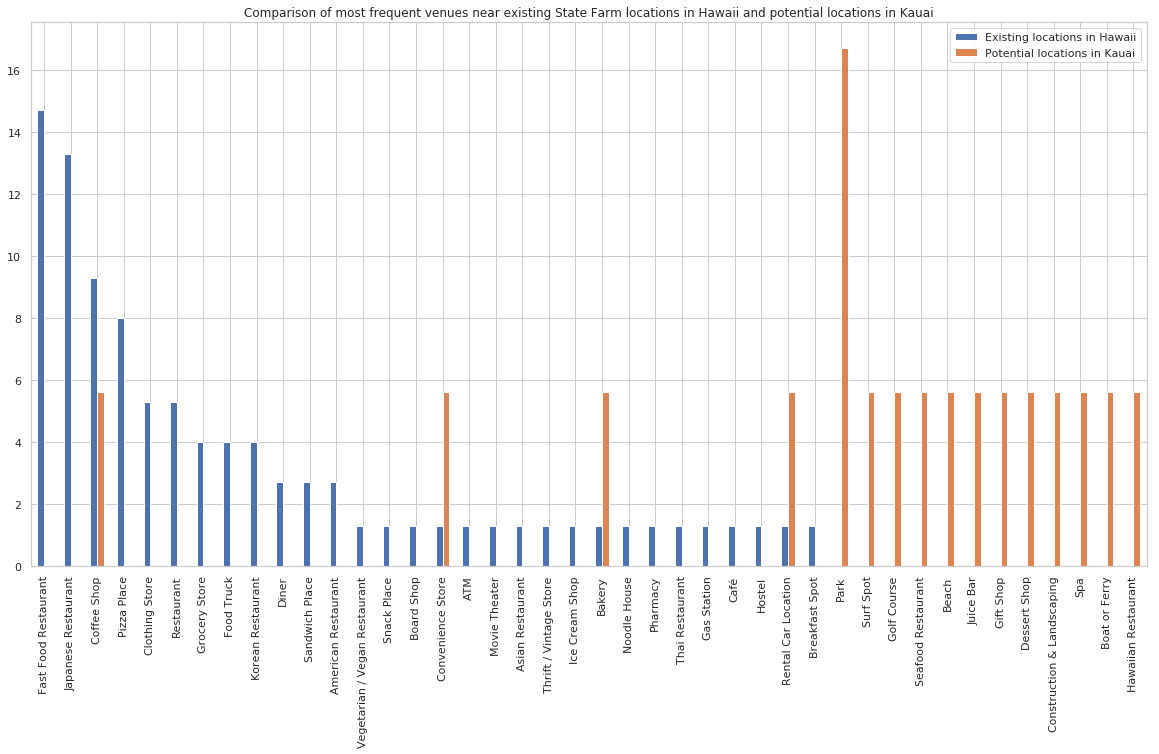

In [24]:
#Graph the most common venue
plottitle='Comparison of most frequent venues near existing State Farm locations in Hawaii and potential locations in Kauai'
countdf.plot(y=['Existing locations in Hawaii', 'Potential locations in Kauai'], kind='bar',figsize=(20,10), title=plottitle)

Immediately, we see some potential candidates for a Kauai State Farm agency: namely, those potential locations which share a primary venue with an existing location. These locations are given as follows:

In [38]:
goodvenueslist = countdf[(countdf['Existing locations in Hawaii']>0) & (countdf['Potential locations in Kauai']>0)][['Existing locations in Hawaii', 'Potential locations in Kauai']].index
edastores=kauai_venues_sorted['Store'][kauai_venues_sorted['1st Most Common Venue'].isin(goodvenueslist)]
print(edastores)


7     Kaumakani
10        Koloa
11        Lawai
12        Lihue
Name: Store, dtype: object


#### K-means clustering analysis
We next turn our attention to a *k-means clustering* analysis whereby we will form clusters of existing and potential locations of State Farm Agencies. This will allow us to find the suitability of potential Kauai locations by their adherence to clusters with large adherents of existing locations.

In [39]:
# CREATE THE CLUSTERS

# set number of clusters
kclusters = 25

combined_grouped =  pd.concat([hawaii_grouped, kauai_grouped], sort=False).fillna(0)

combined_grouped_clustering = combined_grouped.drop('Store', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(combined_grouped_clustering)


# drop old clustering labels if they exist
if 'Cluster Labels' in hawaii_venues_sorted.columns:
        hawaii_venues_sorted = hawaii_venues_sorted.drop(columns='Cluster Labels', axis=1)
if 'Cluster Labels' in kauai_venues_sorted.columns:
       kauai_venues_sorted = kauai_venues_sorted.drop(columns='Cluster Labels', axis=1)

existinglocs = len(hawaii_grouped.axes[0])
potentiallocs = len(kauai_grouped.axes[0])

hawaiilabels=kmeans.labels_[0:existinglocs]
kauailabels=kmeans.labels_[existinglocs:existinglocs+potentiallocs]


clusterfreq = pd.Series(hawaiilabels).value_counts()

bestcluster = list(clusterfreq.index.values)[0]

clusterstores = kauai_grouped[kauailabels==bestcluster].Store
print(clusterstores)


1      Hanalei
3     Hanapepe
9      Kilauea
10       Koloa
17      Waimea
Name: Store, dtype: object


In [41]:
# Find the potential store locations which were best in both analyses
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

best = edastores.loc[edastores.index & clusterstores.index]

print('Best potential location(s) from Exploratory Data Analysis: \n', edastores)
print('Best potential location(s) from K-means Clustering Analysis: \n',clusterstores)
print('Best potential location(s) overall: \n', best) 

Best potential location(s) from Exploratory Data Analysis: 
 7     Kaumakani
10        Koloa
11        Lawai
12        Lihue
Name: Store, dtype: object
Best potential location(s) from K-means Clustering Analysis: 
 1      Hanalei
3     Hanapepe
9      Kilauea
10       Koloa
17      Waimea
Name: Store, dtype: object
Best potential location(s) overall: 
 10    Koloa
Name: Store, dtype: object


### Results
We performed two distinct analyses: one rooted in *Exploratroy Data Analysis* showed several potential locations (indicated with orange circles in the map below) and one rooted in *k-means clustering* (indicated by blue circles in the map below). Looking at the intersection of these potential candidates leads to a single candidate for a State Farm agency in Kauai: Koloa. This locaion is indicated on the following map with the blue marker. 

In [116]:
# Create a Kauai data frame with results of Exploratory Data Analysis and Clustering

if 'Label' in kauai_data.columns:
    del kauai_data['Label']

kauai_towns = kauai_data['Town']

def townlabeler(town):
    if town in best.unique():
        lbl = "Both"
    else:
        if town in edastores.unique():
            lbl= "EDA"
        else:
            if town in clusterstores.unique():
                lbl= "Clustering"
            else:
                lbl="None"
    return lbl

def townlister(townlist):
    l = len(townlist)
    print(l)
    townlistlabels=pd.Series(l)
    for i in range(len(townlist)):
        townlabel = townlabeler(townlist[i])
        townlistlabels[i]=townlabel
    return townlistlabels
            

kauai_labels = townlister(kauai_towns)


kauai_data['Label'] = kauai_labels

both_data = kauai_data[kauai_data['Label']=="Both"]
eda_data = kauai_data[kauai_data['Label']=="EDA"]
cluster_data = kauai_data[kauai_data['Label']=="Clustering"]
none_data = kauai_data[kauai_data['Label']=="None"]

# Create the cluster map

potentialmap = folium.Map(location=[22, -160], zoom_start=9)

clusterlocations = cluster_data[['Latitude', 'Longitude']]
clusterlocationlist = locations.values.tolist()


for point in range(0, len(clusterlocationlist)):
    folium.CircleMarker(clusterlocationlist[point], color='blue').add_to(potentialmap)
    
edalocations = eda_data[['Latitude', 'Longitude']]
edalocationlist = edalocations.values.tolist()

for point in range(0, len(edalocationlist)):
    folium.CircleMarker(edalocationlist[point],color='orange').add_to(potentialmap)    
    
nonelocations = none_data[['Latitude', 'Longitude']]
nonelocationlist = nonelocations.values.tolist()

for point in range(0, len(nonelocationlist)):
    folium.CircleMarker(nonelocationlist[point], color='red').add_to(potentialmap)        

bothlocations = both_data[['Latitude', 'Longitude']]
bothlocationlist = bothlocations.values.tolist()

for point in range(0, len(bothlocationlist)):
    folium.Marker(bothlocationlist[point], color='green').add_to(potentialmap)        
    
    
potentialmap




20


### Discussion
The analyses provided were successful in establishing a single location for the State Farm agency in Kauai (Koloa). Although the analysis used two distinct *methods*, it was fundamentally predicated on the notion that a good location for an insurance agency can be determined by looking at nearby venues of existing agencies. While this seems like a reasonable consideration, we should introduce other indicators of an agency location viability, such as real estate values, population demographcis, accessiblility and likey foot traffic.

### Conlcusion
Using rudimentary *Exploraroty Data Analysis* and *k-means clustering* can indicate viability of an inusrance location based on the narrow view of finding similarities with successful insurance agency locations regarding other nearby venues. In our analysis of comparing potential locations in Kauai with existing locations on other islands in Hawaii, we were able to suggest a candidate location for our agency. However, we recommend further study of other characteristics before settling on a location. 
